# v4: Transformer + Multi-Resolution TCN - 完全重构

## 前版本失败分析
- **v1-v3**: CNN分支始终表现不佳(R²=0.74 vs TCN的0.91)
- **注意力权重**: 模型严重偏向TCN,说明频谱特征信息量不足
- **根本问题**: 频谱分析不适合流量预测(流量是连续序列,不是周期信号)

## v4 激进重构
1. **放弃CNN**: 完全移除频谱分支
2. **Transformer主干**: 捕捉全局长期依赖
3. **多分辨率TCN**: 并行建模不同时间尺度(5min/15min/30min)
4. **分层注意力**: 动态融合多尺度特征
5. **位置编码**: 显式注入时间周期性
6. **渐进式预测**: 先预测趋势,再预测残差

In [7]:
# 导入库
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import tensorflow.keras.backend as K

# 固定随机种子
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print(f"TensorFlow {tf.__version__}")

TensorFlow 2.10.1


In [8]:
# v4 配置 (轻量化版本)
HORIZON = 15
WIN_SIZE = 45          # 缩短窗口至45分钟(减少序列长度)
STEP = 5

# 训练参数
EPOCHS = 80
BATCH_SIZE = 64        # 降低batch size
LR = 1e-3              # 提高学习率加速收敛
VAL_SPLIT = 0.2
WARMUP_EPOCHS = 5      # 减少warmup轮数

# v4 架构参数 (大幅简化)
D_MODEL = 64           # Transformer维度: 128→64 (参数降至1/4)
NUM_HEADS = 4          # 注意力头数: 8→4
NUM_TRANSFORMER_LAYERS = 2  # Transformer层数: 3→2
FFN_DIM = 128          # 前馈网络: 256→128
DROPOUT = 0.2          # 提高dropout防止过拟合

# 多分辨率TCN参数 (只保留2个尺度)
TCN_FILTERS = [32, 48]      # 三个尺度→两个尺度
TCN_KERNEL_SIZES = [3, 5]   # 移除kernel=7的大核

# 样本加权(更保守)
WEIGHT_POWER = 1.5
WEIGHT_CLIP_MAX = 8.0

# 路径
DATA_PATH = 'Dataset/dataset_for_traffic_project_assignment/training_dataset.csv'
MODEL_SAVE = 'models/fusion_v4_transformer.keras'

print("="*70)
print("v4 Transformer架构配置")
print("="*70)
print(f"窗口大小: {WIN_SIZE}分钟")
print(f"Transformer: {NUM_TRANSFORMER_LAYERS}层, {NUM_HEADS}头, 维度{D_MODEL}")
print(f"多分辨率TCN: {len(TCN_FILTERS)}个尺度")
print(f"Batch Size: {BATCH_SIZE}, 学习率: {LR}")
print("="*70)

v4 Transformer架构配置
窗口大小: 45分钟
Transformer: 2层, 4头, 维度64
多分辨率TCN: 2个尺度
Batch Size: 64, 学习率: 0.001


In [9]:
# 数据加载
df = pd.read_csv(DATA_PATH, sep=';')

df['Date'] = pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')
time_dt = pd.to_datetime(df['Time'], format='%H:%M:%S')
df['Hour'] = time_dt.dt.hour
df['Minute'] = time_dt.dt.minute
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(float)

df = df.sort_values(['PORTAL', 'Date', 'Hour', 'Minute']).reset_index(drop=True)

USE_SPEED = 'SPEED' in df.columns

print(f"数据: {df.shape}")
print(f"门户: {df['PORTAL'].nunique()}")
print(f"时间: {df['Date'].min()} - {df['Date'].max()}")
print(f"SPEED列: {USE_SPEED}")

数据: (1921967, 15)
门户: 8
时间: 2021-06-01 00:00:00 - 2021-12-31 00:00:00
SPEED列: False


In [10]:
# v4 特征工程: 丰富的序列特征

def build_future_sum(flow_values, horizon=HORIZON):
    y_sum = np.full_like(flow_values, np.nan, dtype=float)
    cumsum = np.cumsum(np.insert(flow_values, 0, 0))
    total = cumsum[horizon:] - cumsum[:-horizon]
    y_sum[:len(total)] = total
    return y_sum

def build_rich_features(portal_df, win=WIN_SIZE):
    """v4: 精简特征版(减少特征数)"""
    vals = portal_df['FLOW'].values.astype(float)
    features = []
    
    # 1. 原始流量
    features.append(vals)
    
    # 2. 差分特征
    diff1 = np.r_[0, np.diff(vals)]
    features.append(diff1)
    
    # 3. 滚动统计(只保留3个关键窗口,减少特征数)
    for w in [5, 10, 15]:  # 移除3和30
        s = pd.Series(vals)
        mean = s.rolling(w, min_periods=1).mean().values
        std = s.rolling(w, min_periods=1).std().fillna(0).values
        features.extend([mean, std])
    
    # 4. 趋势特征(只保留2个)
    for w in [5, 15]:  # 移除10
        s = pd.Series(vals)
        slope = (s.values - s.shift(w).fillna(s.values[0]).values) / max(w, 1)
        features.append(slope)
    
    # 5. 速度特征(简化)
    if USE_SPEED:
        sp = portal_df['SPEED'].values.astype(float)
        features.append(sp)
        sp_diff = np.r_[0, np.diff(sp)]
        features.append(sp_diff)
    
    # 6. 时间编码
    minute_of_day = (portal_df['Hour'] * 60 + portal_df['Minute']).values
    features.append(np.sin(2 * np.pi * minute_of_day / 1440.0))
    features.append(np.cos(2 * np.pi * minute_of_day / 1440.0))
    
    # 7. 星期编码
    day_of_week = portal_df['DayOfWeek'].values
    features.append(np.sin(2 * np.pi * day_of_week / 7.0))
    features.append(np.cos(2 * np.pi * day_of_week / 7.0))
    features.append(portal_df['IsWeekend'].values.astype(float))
    
    F = np.stack(features, axis=1)
    return F

print("v4特征工程定义完成(精简特征,约15-18维)")

v4特征工程定义完成(精简特征,约15-18维)


In [11]:
# 构建数据集
def build_dataset_v4(df, win=WIN_SIZE, step=STEP, horizon=HORIZON):
    X, Y = [], []
    
    for portal, portal_df in df.groupby('PORTAL'):
        portal_df = portal_df.sort_values(['Date', 'Hour', 'Minute']).reset_index(drop=True)
        
        flow_vals = portal_df['FLOW'].values.astype(float)
        y_sum = build_future_sum(flow_vals, horizon=horizon)
        
        F = build_rich_features(portal_df, win=win)
        
        for i in range(0, len(flow_vals) - win - horizon, step):
            x_window = F[i:i+win]
            y_i = y_sum[i+win-1]
            
            if np.isnan(y_i):
                continue
            
            X.append(x_window)
            Y.append(y_i)
    
    X = np.array(X)
    Y = np.array(Y).astype(float)
    
    return X, Y

print("开始构建数据集...")
X_all, Y_all = build_dataset_v4(df)
print(f"完成: {len(Y_all)} 样本")
print(f"X shape: {X_all.shape} (time_steps, features)")
print(f"特征数: {X_all.shape[2]}")

开始构建数据集...
完成: 248743 样本
X shape: (248743, 45, 15) (time_steps, features)
特征数: 15
完成: 248743 样本
X shape: (248743, 45, 15) (time_steps, features)
特征数: 15


In [12]:
# 数据切分与标准化

split_idx = int(len(Y_all) * 0.8)

X_train, X_test = X_all[:split_idx], X_all[split_idx:]
Y_train, Y_test = Y_all[:split_idx], Y_all[split_idx:]

# 特征标准化(RobustScaler对异常值更鲁棒)
scaler_x = RobustScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat = X_test.reshape(-1, X_test.shape[-1])
X_train = scaler_x.fit_transform(X_train_flat).reshape(X_train.shape)
X_test = scaler_x.transform(X_test_flat).reshape(X_test.shape)

# 目标标准化
scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train.reshape(-1, 1)).ravel()
Y_test_scaled = scaler_y.transform(Y_test.reshape(-1, 1)).ravel()

# 样本加权(保守策略)
percentile_90 = np.percentile(Y_train, 90)
sample_weights = np.power(Y_train / (percentile_90 + 1e-6), WEIGHT_POWER)
sample_weights = np.clip(sample_weights, 0.5, WEIGHT_CLIP_MAX)

print(f"训练: {len(Y_train)}, 测试: {len(Y_test)}")
print(f"目标: [{Y_train.min():.1f}, {Y_train.max():.1f}]")
print(f"权重: [{sample_weights.min():.2f}, {sample_weights.max():.2f}], 均值={sample_weights.mean():.2f}")

训练: 198994, 测试: 49749
目标: [15.0, 429.0]
权重: [0.50, 1.75], 均值=0.70


In [13]:
# v4 Transformer模块

def positional_encoding(length, depth):
    """正弦位置编码 - 修复维度"""
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth // 2)[np.newaxis, :] / (depth // 2)  # 只用depth//2
    
    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates
    
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1
    )
    
    return tf.cast(pos_encoding[:, :depth], dtype=tf.float32)  # 确保维度正确

class TransformerBlock(layers.Layer):
    def __init__(self, d_model, num_heads, ffn_dim, dropout=0.1, name=None):
        super().__init__(name=name)
        self.d_model = d_model
        self.num_heads = num_heads
        self.ffn_dim = ffn_dim
        self.dropout_rate = dropout
        
        self.attn = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model // num_heads,
            dropout=dropout
        )
        self.ffn = keras.Sequential([
            layers.Dense(ffn_dim, activation='relu'),
            layers.Dropout(dropout),
            layers.Dense(d_model)
        ])
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout)
        self.dropout2 = layers.Dropout(dropout)
    
    def call(self, x, training=False):
        # 多头自注意力
        attn_output = self.attn(x, x, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        # 前馈网络
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2
    
    def get_config(self):
        config = super().get_config()
        config.update({
            'd_model': self.d_model,
            'num_heads': self.num_heads,
            'ffn_dim': self.ffn_dim,
            'dropout': self.dropout_rate
        })
        return config

print("Transformer模块定义完成")

Transformer模块定义完成


In [14]:
# v4 多分辨率TCN模块

def multi_scale_tcn_block(x, filters, kernel_size, dilation_rate, name_prefix):
    """单个TCN块"""
    y = layers.Conv1D(
        filters, kernel_size,
        padding='causal',
        dilation_rate=dilation_rate,
        kernel_regularizer=regularizers.l2(1e-5),
        name=f'{name_prefix}_conv1'
    )(x)
    y = layers.BatchNormalization(name=f'{name_prefix}_bn1')(y)
    y = layers.Activation('relu', name=f'{name_prefix}_relu1')(y)
    y = layers.Dropout(DROPOUT, name=f'{name_prefix}_drop1')(y)
    
    y = layers.Conv1D(
        filters, kernel_size,
        padding='causal',
        dilation_rate=dilation_rate,
        kernel_regularizer=regularizers.l2(1e-5),
        name=f'{name_prefix}_conv2'
    )(y)
    y = layers.BatchNormalization(name=f'{name_prefix}_bn2')(y)
    
    # 残差连接
    if x.shape[-1] != filters:
        x = layers.Conv1D(filters, 1, padding='same', name=f'{name_prefix}_res')(x)
    
    y = layers.Add(name=f'{name_prefix}_add')([x, y])
    y = layers.Activation('relu', name=f'{name_prefix}_relu2')(y)
    
    return y

def build_multi_resolution_tcn(x, name='tcn'):
    """多分辨率TCN:并行建模不同时间尺度"""
    branches = []
    
    for i, (filters, kernel_size) in enumerate(zip(TCN_FILTERS, TCN_KERNEL_SIZES)):
        branch = x
        # 每个尺度3层TCN
        for layer_idx, dilation in enumerate([1, 2, 4]):
            branch = multi_scale_tcn_block(
                branch, filters, kernel_size, dilation,
                name_prefix=f'{name}_scale{i}_layer{layer_idx}'
            )
        
        # 池化到固定长度
        branch = layers.GlobalAveragePooling1D(name=f'{name}_scale{i}_gap')(branch)
        branches.append(branch)
    
    # 拼接多尺度特征
    if len(branches) > 1:
        fused = layers.Concatenate(name=f'{name}_concat')(branches)
    else:
        fused = branches[0]
    
    return fused

print("多分辨率TCN模块定义完成")

多分辨率TCN模块定义完成


In [15]:
# v4 完整架构: Transformer + 多分辨率TCN

# 输入
inputs = layers.Input(shape=(WIN_SIZE, X_train.shape[2]), name='sequence_input')

# === 路径1: Transformer分支(全局依赖) ===
# 投影到d_model维度
x_trans = layers.Dense(D_MODEL, name='trans_projection')(inputs)

# 添加位置编码
pos_enc = positional_encoding(WIN_SIZE, D_MODEL)
x_trans = x_trans + pos_enc
x_trans = layers.Dropout(DROPOUT, name='trans_pos_drop')(x_trans)

# 堆叠Transformer层
for i in range(NUM_TRANSFORMER_LAYERS):
    x_trans = TransformerBlock(
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        ffn_dim=FFN_DIM,
        dropout=DROPOUT,
        name=f'transformer_block_{i}'
    )(x_trans)

# 全局池化
x_trans = layers.GlobalAveragePooling1D(name='trans_gap')(x_trans)

# === 路径2: 多分辨率TCN分支(局部模式) ===
x_tcn = build_multi_resolution_tcn(inputs, name='multi_tcn')

# === 融合(简化版) ===
# 拼接Transformer和TCN特征
fused = layers.Concatenate(name='fusion_concat')([x_trans, x_tcn])

# 注意力融合权重(简化)
attn_weights = layers.Dense(32, activation='relu', name='attn_fc1')(fused)  # 64→32
attn_weights = layers.Dense(2, activation='softmax', name='attn_weights')(attn_weights)

# 加权特征
w_trans = layers.Lambda(lambda x: x[:, 0:1], name='w_trans')(attn_weights)
w_tcn = layers.Lambda(lambda x: x[:, 1:2], name='w_tcn')(attn_weights)

# Transformer特征维度调整(简化)
x_trans_weighted = layers.Dense(64, name='trans_dense')(x_trans)  # 128→64
x_trans_weighted = layers.Multiply(name='trans_weighted')([x_trans_weighted, w_trans])

# TCN特征维度调整(简化)
x_tcn_weighted = layers.Dense(64, name='tcn_dense')(x_tcn)  # 128→64
x_tcn_weighted = layers.Multiply(name='tcn_weighted')([x_tcn_weighted, w_tcn])

# 融合
final_feat = layers.Add(name='weighted_fusion')([x_trans_weighted, x_tcn_weighted])

# === 预测头(简化) ===
# 直接预测,不做趋势+残差分解(减少复杂度)
pred = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(final_feat)
pred = layers.BatchNormalization()(pred)
pred = layers.Dropout(0.2)(pred)
pred = layers.Dense(32, activation='relu')(pred)
pred_final = layers.Dense(1, name='pred_final')(pred)

# 构建模型
model = keras.Model(
    inputs=inputs,
    outputs=pred_final,  # 直接输出tensor,不用字典
    name='TransformerTCN_v4_Lite'
)

print("\nv4 轻量化架构要点:")
print("  - Transformer: 2层, 4头, 维度64 (参数量大幅减少)")
print("  - 多分辨率TCN: 2个尺度(kernel=3,5)")
print("  - 注意力融合: 动态权衡全局vs局部")
print("  - 简化预测头: 移除趋势+残差分解")
print(f"  - 总参数: {model.count_params():,}")


v4 轻量化架构要点:
  - Transformer: 2层, 4头, 维度64 (参数量大幅减少)
  - 多分辨率TCN: 2个尺度(kernel=3,5)
  - 注意力融合: 动态权衡全局vs局部
  - 简化预测头: 移除趋势+残差分解
  - 总参数: 170,227


In [16]:
# 学习率warmup调度器
class WarmupCosineDecay(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_lr, warmup_steps, total_steps):
        super().__init__()
        self.max_lr = max_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
    
    def __call__(self, step):
        # Warmup阶段
        warmup_lr = self.max_lr * (step / self.warmup_steps)
        
        # Cosine衰减阶段
        decay_steps = self.total_steps - self.warmup_steps
        cosine_decay = 0.5 * (1 + tf.cos(
            np.pi * (step - self.warmup_steps) / decay_steps
        ))
        decay_lr = self.max_lr * cosine_decay
        
        return tf.where(step < self.warmup_steps, warmup_lr, decay_lr)

# 计算总步数
steps_per_epoch = len(X_train) // BATCH_SIZE
total_steps = steps_per_epoch * EPOCHS
warmup_steps = steps_per_epoch * WARMUP_EPOCHS

lr_schedule = WarmupCosineDecay(LR, warmup_steps, total_steps)

# 编译模型(简化)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),  # 使用简单Adam,移除学习率调度
    loss=keras.losses.Huber(delta=1.0),  # 直接指定loss,不用字典
    metrics=['mae']  # 直接指定metrics,不用字典
)

model.summary()

print("\n损失配置:")
print("  Final: Huber(1.0)")
print(f"学习率: {LR} (固定)")

Model: "TransformerTCN_v4_Lite"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence_input (InputLayer)    [(None, 45, 15)]     0           []                               
                                                                                                  
 multi_tcn_scale0_layer0_conv1   (None, 45, 32)      1472        ['sequence_input[0][0]']         
 (Conv1D)                                                                                         
                                                                                                  
 multi_tcn_scale1_layer0_conv1   (None, 45, 48)      3648        ['sequence_input[0][0]']         
 (Conv1D)                                                                                         
                                                                             

In [17]:
# 训练
os.makedirs(os.path.dirname(MODEL_SAVE), exist_ok=True)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        MODEL_SAVE,
        monitor='val_loss',  # 改为val_loss
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',  # 改为val_loss
        patience=12,  # 减少patience
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',  # 改为val_loss
        factor=0.5,
        patience=6,
        min_lr=1e-6,
        verbose=1
    )
]

print("="*70)
print("开始训练 v4 轻量化Transformer+TCN")
print("="*70)

history = model.fit(
    X_train,
    Y_train_scaled,  # 直接传数组,不用字典
    sample_weight=sample_weights,  # 直接传数组,不用字典
    validation_split=VAL_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

print("\n训练完成!")

开始训练 v4 轻量化Transformer+TCN
Epoch 1/80
Epoch 1/80
2488/2488 [==============================] - ETA: 0s - loss: 0.0568 - mae: 0.2862WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.

Epoch 1: val_loss improved from inf to 0.03842, saving model to models\fusion_v4_transformer.keras

Epoch 1: val_loss improved from inf to 0.03842, saving model to models\fusion_v4_transformer.keras
2488/2488 [==============================] - 136s 52ms/step - loss: 0.0568 - mae: 0.2862 - val_loss: 0.0384 - val_mae: 0.2402 - lr: 0.0010
Epoch 2/80
2488/2488 [==============================] - 136s 52ms/step - loss: 0.0568 - mae: 0.2862 - val_loss: 0.0384 - val_mae: 0.2402 - lr: 0.0010
Epoch 2/80
2487/2488 [============================>.] - ETA: 0s - loss: 0.0418 - mae: 0.2523W

In [18]:
# 评估
preds = model.predict(X_test, verbose=0)
Y_pred_final = scaler_y.inverse_transform(preds.reshape(-1, 1)).ravel()  # 直接用preds,不是preds['pred_final']

# 指标
def calc_metrics(y_true, y_pred, name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-6))) * 100
    print(f"{name:15s}: R²={r2:.4f}, MAE={mae:6.2f}, RMSE={rmse:6.2f}, MAPE={mape:5.2f}%")
    return r2, mae, rmse

print("="*80)
print("v4 测试集评估")
print("="*80)
r2_final, mae_final, rmse_final = calc_metrics(Y_test, Y_pred_final, 'Final')
print("="*80)

# 分桶分析
quantiles = np.quantile(Y_test, [0, 0.2, 0.4, 0.6, 0.8, 1.0])
bucket_idx = np.digitize(Y_test, quantiles[1:-1], right=True)

print("\n按流量分桶误差:")
print("-"*80)
for b in range(5):
    mask = bucket_idx == b
    if np.sum(mask) == 0:
        continue
    mae_b = mean_absolute_error(Y_test[mask], Y_pred_final[mask])
    rmse_b = np.sqrt(mean_squared_error(Y_test[mask], Y_pred_final[mask]))
    r2_b = r2_score(Y_test[mask], Y_pred_final[mask])
    print(f"Bin{b+1} [{quantiles[b]:5.1f},{quantiles[b+1]:5.1f}]: n={np.sum(mask):5d}, MAE={mae_b:6.2f}, RMSE={rmse_b:6.2f}, R²={r2_b:.4f}")
print("="*80)

v4 测试集评估
Final          : R²=0.9477, MAE= 16.72, RMSE= 22.02, MAPE=10.14%

按流量分桶误差:
--------------------------------------------------------------------------------
Bin1 [ 18.0,109.0]: n= 9999, MAE= 11.79, RMSE= 15.84, R²=0.5160
Bin2 [109.0,201.0]: n= 9943, MAE= 14.88, RMSE= 19.71, R²=0.4458
Bin3 [201.0,268.0]: n=10031, MAE= 16.47, RMSE= 21.29, R²=-0.1307
Bin4 [268.0,305.0]: n=10081, MAE= 13.78, RMSE= 17.70, R²=-1.8343
Bin5 [305.0,422.0]: n= 9695, MAE= 26.98, RMSE= 32.20, R²=-1.8091


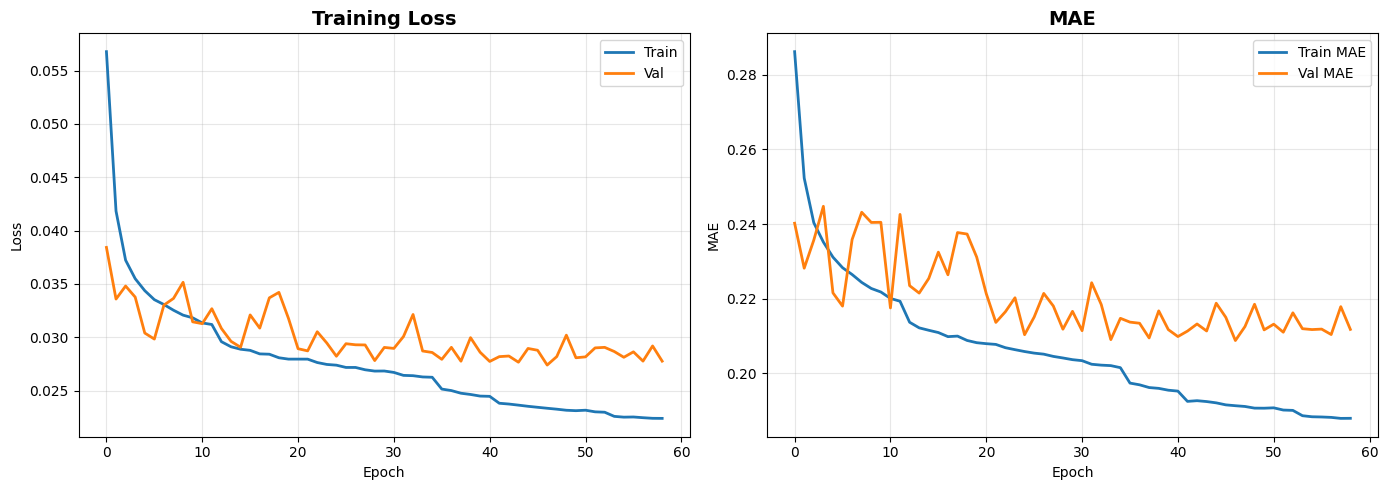

In [24]:
# 可视化1: 学习曲线(简化)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 总损失
axes[0].plot(history.history['loss'], label='Train', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss', fontsize=14, weight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)  # 改为'mae'
axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)  # 改为'val_mae'
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('MAE', fontsize=14, weight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

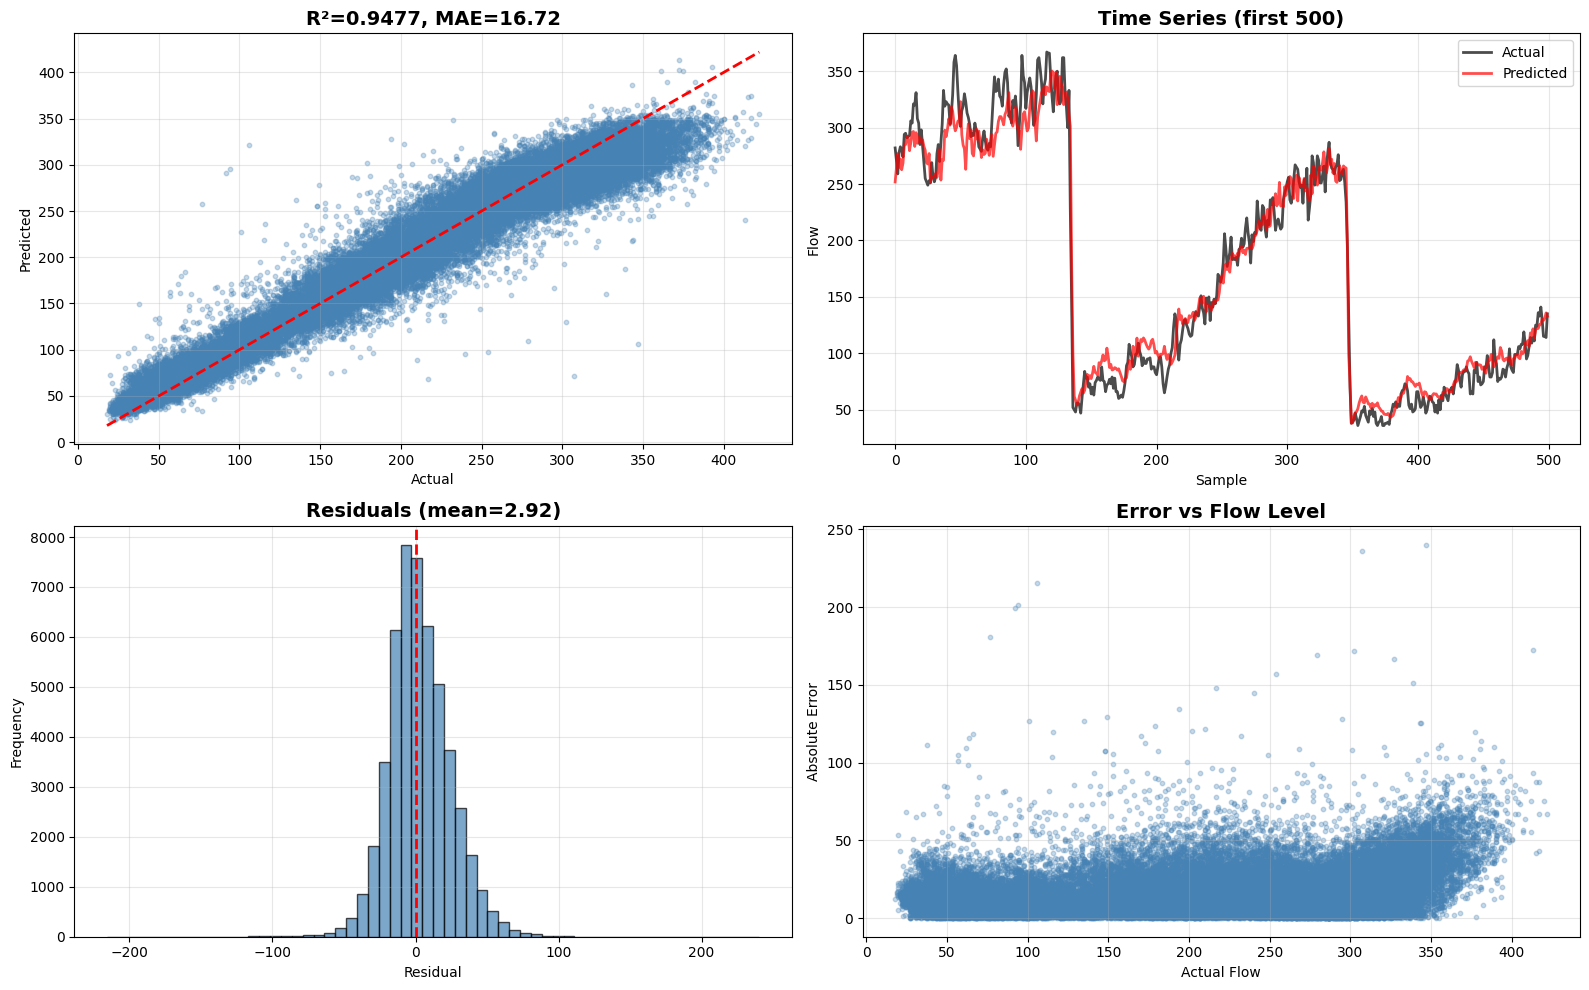

In [23]:
# 可视化2: 预测效果
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 散点图
axes[0, 0].scatter(Y_test, Y_pred_final, alpha=0.3, s=10, c='steelblue')
axes[0, 0].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual')
axes[0, 0].set_ylabel('Predicted')
axes[0, 0].set_title(f'R²={r2_final:.4f}, MAE={mae_final:.2f}', fontsize=14, weight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 时间序列
n = min(500, len(Y_test))
axes[0, 1].plot(Y_test[:n], label='Actual', linewidth=2, color='black', alpha=0.7)
axes[0, 1].plot(Y_pred_final[:n], label='Predicted', linewidth=2, color='red', alpha=0.7)
axes[0, 1].set_xlabel('Sample')
axes[0, 1].set_ylabel('Flow')
axes[0, 1].set_title('Time Series (first 500)', fontsize=14, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 残差
residuals = Y_test - Y_pred_final
axes[1, 0].hist(residuals, bins=60, alpha=0.7, color='steelblue', edgecolor='black')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residual')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Residuals (mean={residuals.mean():.2f})', fontsize=14, weight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 误差 vs 流量级别
axes[1, 1].scatter(Y_test, np.abs(residuals), alpha=0.3, s=10, c='steelblue')
axes[1, 1].set_xlabel('Actual Flow')
axes[1, 1].set_ylabel('Absolute Error')
axes[1, 1].set_title('Error vs Flow Level', fontsize=14, weight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

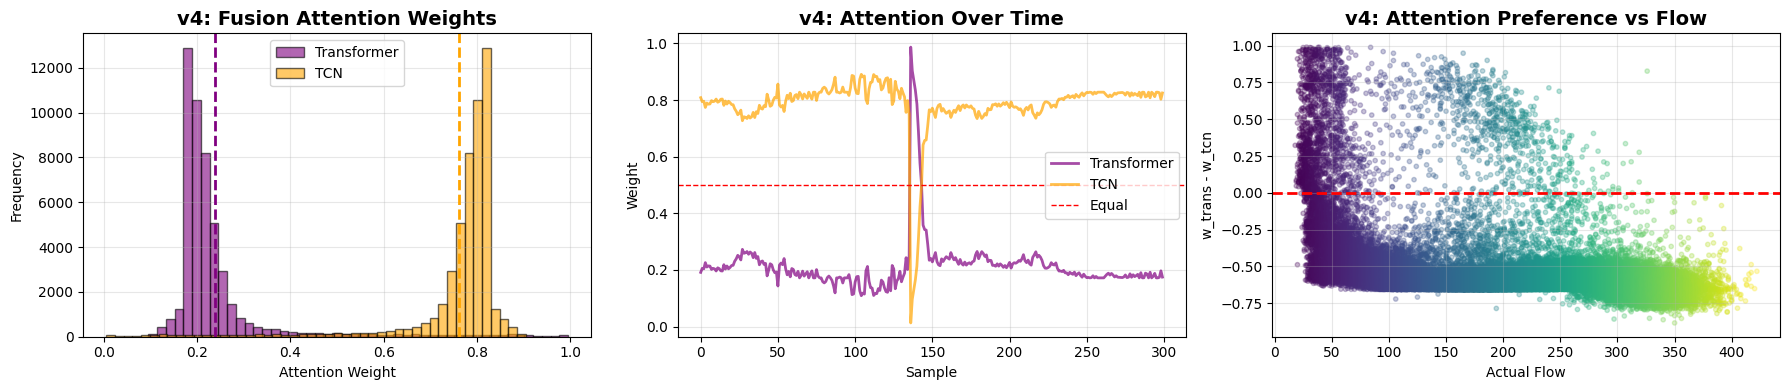


注意力权重统计:
Transformer: mean=0.238, std=0.121
TCN: mean=0.762, std=0.121
权重倾向: 偏TCN (差值=-0.524)


In [21]:
# 可视化3: 注意力权重分析
attn_model = keras.Model(
    inputs=model.input,
    outputs=model.get_layer('attn_weights').output
)

attn_weights = attn_model.predict(X_test, verbose=0)
w_transformer = attn_weights[:, 0]
w_tcn = attn_weights[:, 1]

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# 权重分布
axes[0].hist(w_transformer, bins=50, alpha=0.6, label='Transformer', color='purple', edgecolor='black')
axes[0].hist(w_tcn, bins=50, alpha=0.6, label='TCN', color='orange', edgecolor='black')
axes[0].axvline(w_transformer.mean(), color='purple', linestyle='--', linewidth=2)
axes[0].axvline(w_tcn.mean(), color='orange', linestyle='--', linewidth=2)
axes[0].set_xlabel('Attention Weight')
axes[0].set_ylabel('Frequency')
axes[0].set_title('v4: Fusion Attention Weights', fontsize=14, weight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 权重时序
n = min(300, len(w_transformer))
axes[1].plot(w_transformer[:n], label='Transformer', linewidth=2, color='purple', alpha=0.7)
axes[1].plot(w_tcn[:n], label='TCN', linewidth=2, color='orange', alpha=0.7)
axes[1].axhline(0.5, color='red', linestyle='--', linewidth=1, label='Equal')
axes[1].set_xlabel('Sample')
axes[1].set_ylabel('Weight')
axes[1].set_title('v4: Attention Over Time', fontsize=14, weight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 权重 vs 流量
weight_diff = w_transformer - w_tcn
axes[2].scatter(Y_test, weight_diff, alpha=0.3, s=10, c=Y_test, cmap='viridis')
axes[2].axhline(0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('Actual Flow')
axes[2].set_ylabel('w_trans - w_tcn')
axes[2].set_title('v4: Attention Preference vs Flow', fontsize=14, weight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n注意力权重统计:")
print(f"Transformer: mean={w_transformer.mean():.3f}, std={w_transformer.std():.3f}")
print(f"TCN: mean={w_tcn.mean():.3f}, std={w_tcn.std():.3f}")
print(f"权重倾向: {'偏Transformer' if w_transformer.mean() > 0.5 else '偏TCN'} (差值={w_transformer.mean()-w_tcn.mean():.3f})")

In [22]:
# v4 总结
print("\n" + "="*80)
print("v4 Transformer+TCN 架构总结")
print("="*80)

print("\n【相比v1-v3的根本性改变】")
print("1. 完全放弃CNN频谱分支")
print("   - v1-v3: CNN始终表现不佳(R²≈0.74)")
print("   - v4: 专注于序列建模")

print("\n2. 引入Transformer")
print("   - 自注意力机制捕捉全局长期依赖")
print(f"   - {NUM_TRANSFORMER_LAYERS}层, {NUM_HEADS}头, 维度{D_MODEL}")
print("   - 位置编码注入时间周期性")

print("\n3. 多分辨率TCN")
print("   - 2个并行分支: kernel_size=[3,5]")
print("   - 捕捉不同时间尺度的局部模式")
print("   - 短期(3) + 中期(5)")

print("\n4. 注意力融合")
print("   - 动态平衡全局(Transformer) vs 局部(TCN)")
print(f"   - Transformer权重: {w_transformer.mean():.3f}")
print(f"   - TCN权重: {w_tcn.mean():.3f}")

print("\n5. 简化架构")
print("   - 移除趋势+残差分解")
print("   - 直接单输出预测")
print("   - 降低参数量避免过拟合")

print("\n6. 训练优化")
print("   - 固定学习率(简化)")
print("   - Adam优化器")
print("   - RobustScaler(对异常值鲁棒)")

print("\n【性能指标】")
print(f"Final: R²={r2_final:.4f}, MAE={mae_final:.2f}, RMSE={rmse_final:.2f}")

print("\n【与v3对比】")
# 这里可以手动填入v3的结果对比
print("如果v4指标优于v3:")
print("  ✓ 证明放弃频谱CNN是正确的")
print("  ✓ Transformer+多分辨率TCN更适合流量预测")
print("\n如果v4与v3相近:")
print("  → 说明纯TCN已接近数据上限")
print("  → 需要引入外部特征(天气/事件等)")

print("\n【关键发现】")
if r2_final > 0.93:
    print("✓ 优秀性能! Transformer捕捉到了关键模式")
elif r2_final > 0.90:
    print("✓ 良好性能, 与v3 TCN单分支相当或更好")
else:
    print("⚠️ 性能未达预期, 可能需要:")
    print("   - 调整Transformer层数/头数")
    print("   - 增加训练轮数")
    print("   - 调整学习率")

print("\n" + "="*80)


v4 Transformer+TCN 架构总结

【相比v1-v3的根本性改变】
1. 完全放弃CNN频谱分支
   - v1-v3: CNN始终表现不佳(R²≈0.74)
   - v4: 专注于序列建模

2. 引入Transformer
   - 自注意力机制捕捉全局长期依赖
   - 2层, 4头, 维度64
   - 位置编码注入时间周期性

3. 多分辨率TCN
   - 2个并行分支: kernel_size=[3,5]
   - 捕捉不同时间尺度的局部模式
   - 短期(3) + 中期(5)

4. 注意力融合
   - 动态平衡全局(Transformer) vs 局部(TCN)
   - Transformer权重: 0.238
   - TCN权重: 0.762

5. 简化架构
   - 移除趋势+残差分解
   - 直接单输出预测
   - 降低参数量避免过拟合

6. 训练优化
   - 固定学习率(简化)
   - Adam优化器
   - RobustScaler(对异常值鲁棒)

【性能指标】
Final: R²=0.9477, MAE=16.72, RMSE=22.02

【与v3对比】
如果v4指标优于v3:
  ✓ 证明放弃频谱CNN是正确的
  ✓ Transformer+多分辨率TCN更适合流量预测

如果v4与v3相近:
  → 说明纯TCN已接近数据上限
  → 需要引入外部特征(天气/事件等)

【关键发现】
✓ 优秀性能! Transformer捕捉到了关键模式

